In [165]:
import json
import importlib
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import transform_data
importlib.reload(transform_data)
import frequencies
importlib.reload(frequencies)

<module 'frequencies' from 'd:\\Research\\tonal-adaptation\\frequencies.py'>

In [166]:
# import data
data = {}

with open("./data/output_data.json", "r") as output_data_file:
    try:
        data = json.load(output_data_file)["words"]
    except Exception as e:
        print(e)

In [167]:
# handle data
X = []
y = []

onset_frequencies = { }
tone_frequencies = { }

for word_en, word_data in data.items():
    onset = word_data["onset_en_ipa"]
    onset_frequencies[onset] = onset_frequencies[onset] + 1 if onset in onset_frequencies else 1

    tone = word_data["onset_tone_num"]
    tone_frequencies[tone] = tone_frequencies[tone] + 1 if tone in tone_frequencies else 1

frequencies, cond_probs = frequencies.get_data()

for word_en, word_data in data.items():
    onset = word_data["onset_en_ipa"][0]
    x = transform_data.vowel_qualities(word_data["onset_en_ipa"][0])
    x.append(word_data["stresses_en"][0])
    x.append(onset_frequencies[word_data["onset_en_ipa"]])
    # x.append(tone_frequencies[word_data["onset_tone_num"]])

    X.append(x)
    y.append(word_data["onset_tone_num"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [168]:
# create, train, and test model
clf = DecisionTreeClassifier(criterion = "gini", random_state=100, max_depth=int(len(X)/10), min_samples_leaf=5)

print(X_train)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

[[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 14], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 42], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 42], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 26], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 26], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 53], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 26], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 42], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 26], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 26], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 16], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 53], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 26], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 42], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 53], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 42], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 18], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 53], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 5], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 9], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 53], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 

[([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 53], 1, 4), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 53], 1, 4), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 42], 1, 1), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 42], 4, 1), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 53], 1, 4), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 12], 4, 4), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 26], 4, 4), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 53], 1, 4), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 53], 1, 4), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 26], 1, 4), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 5], 1, 4), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 26], 1, 1), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 8], 1, 1), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 9], 1, 1), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 12], 4, 4), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2], 4, 1), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 42], 1, 1), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 42], 4, 1), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 18], 4, 4), ([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 42], 1, 1), ([1

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


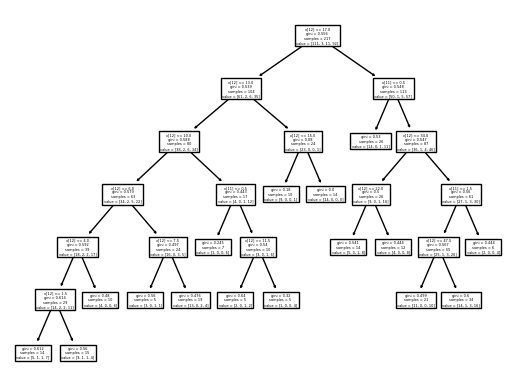

In [169]:
# display tree
plot_tree(clf)

# print outut
tone_comparisons = list(zip(X_test, y_test, y_pred))
print(tone_comparisons)

# print metrics
tone_counts = [0, 0, 0, 0]
tone_corrects = [0, 0, 0, 0]

for tone_comparison in tone_comparisons:
    tone = int(tone_comparison[1])-1
    tone_counts[tone] = tone_counts[tone] + 1

    if tone_comparison[1] == tone_comparison[2]:
        tone_corrects[tone] = tone_corrects[tone] + 1

for t in range(4):
    print(f"tone {t+1} accuracy: {tone_corrects[t]}/{tone_counts[t]} ({tone_corrects[t]/tone_counts[t] * 100}%)")

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred) * 100)
print(classification_report(y_test, y_pred))